# Comparison Opal data and ActiGraph data - lab walk

## Comparison

Data was collected simultaneously for walking in a lab setting (back and forth 10 times across a 30 m corridor) and while walking outside. The lab walk was more consistent speed, while the outside was varied (pausing, much more turning, up and down in elevation, etc).

Synchronization was performed by standing still for 10 seconds, jumping 3 times, standing still for another 10 seconds, and then starting the walking bout. Data was then manually synchronized to the jumping point in sync_imu_data.py.

In this file, let's compare MobGap outputs for the lab based walk.

# Raw data

Below we read and visualize the raw data for the lab based walking bout (for 1 participant). Note that the Opal acceleration data is in m/s^2 and ActiGraph in units of g by default.

Using pq file data/apdm/apdm_subj1_lab_imu_data.parquet


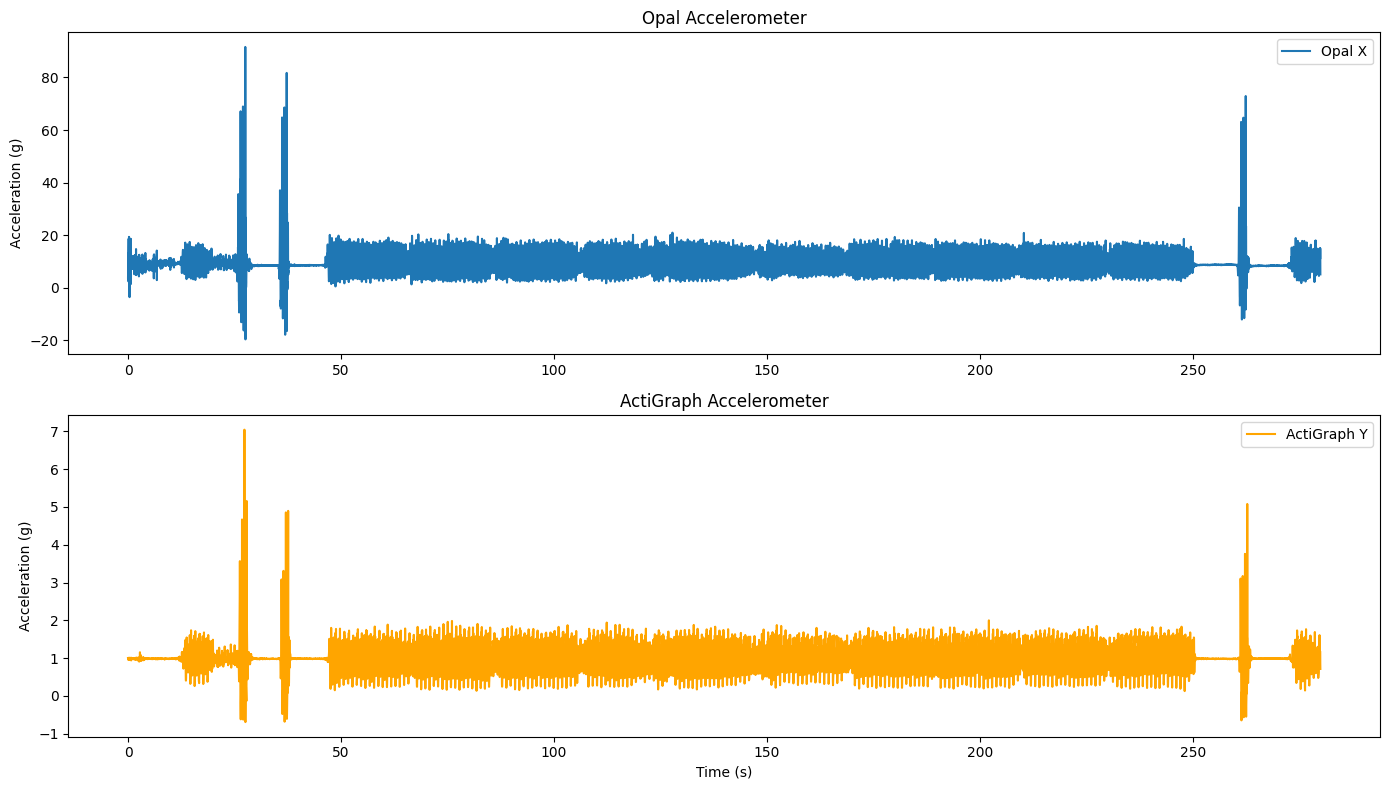

In [ ]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Where all the data is stored
pq_file = "data/apdm/apdm_subj1_lab_imu_data.parquet"
csv_file = "data/actigraph/actigraph_subj1_lab/data_acc_trimmed.csv"

fs_opal = 128
fs_actigraph = 30
t_max = 280

opal_imu_data = pd.read_parquet(pq_file)

# Get acc data for session
session = "test"
seek_column = session + "/LUMBAR/Accelerometer"
acc_data_opal = opal_imu_data.filter(regex=seek_column).to_numpy()
print("Using pq file " + pq_file)

# Actigraph acc
actigraph_data = pd.read_csv(csv_file)
acc_data_actigraph = actigraph_data[['Accelerometer X', 'Accelerometer Y', 'Accelerometer Z']].to_numpy()

# Create time axes
t_actigraph = np.arange(0, len(acc_data_actigraph)) / fs_actigraph
t_opal = np.arange(0, len(acc_data_opal)) / fs_opal

# Trim end
acc_data_opal = acc_data_opal[0:t_max*fs_opal]
acc_data_actigraph = acc_data_actigraph[0:t_max*fs_actigraph]
t_opal = t_opal[0:t_max*fs_opal]
t_actigraph = t_actigraph[0:t_max*fs_actigraph]

#Plot in two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
axs[0].plot(t_opal, -acc_data_opal[:, 0], label='Opal X')
axs[0].set_title('Opal Accelerometer')
axs[0].set_ylabel('Acceleration (m/s2)')
axs[0].legend()
axs[1].plot(t_actigraph, acc_data_actigraph[:, 1], label='ActiGraph Y', color='orange')
axs[1].set_title('ActiGraph Accelerometer')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Acceleration (g)')
axs[1].legend()
plt.tight_layout()
plt.show()

# Preparing data

Let's put the data into proper MobGap dataframes before running their various algorithms.

We will just put gyroscope and magnetometer data to 0 for the ActiGraph.

           acc_x     acc_y     acc_z      gyr_x      gyr_y      gyr_z  \
0       8.531600 -0.011581 -4.616441   0.180410  -0.799275   0.309335   
1       8.533000 -0.023781 -4.637441   0.299012  -0.506494   0.421635   
2       8.498400 -0.058981 -4.627241   0.190150  -0.547174   0.428511   
3       8.473300 -0.061081 -4.603541   0.588356  -0.146103   0.370642   
4       8.471900 -0.072581 -4.590641   0.669716  -0.642858   0.540810   
...          ...       ...       ...        ...        ...        ...   
26875  13.513315 -0.313597 -5.270721  20.471375  12.409200  32.820801   
26876  12.693115  0.712103 -4.880021  23.989336  26.396819  35.892428   
26877  11.147215  1.738003 -4.558621  23.191206  39.086115  34.890325   
26878   9.525515  2.440603 -4.483421  19.721373  38.334394  32.566981   
26879   8.225115  2.824203 -4.191721  14.607152  29.344113  28.908645   

          mag_x     mag_y     mag_z  samples  
0     -0.047700  0.012256  0.017346        0  
1     -0.047903  0.012244  0.

<Axes: >

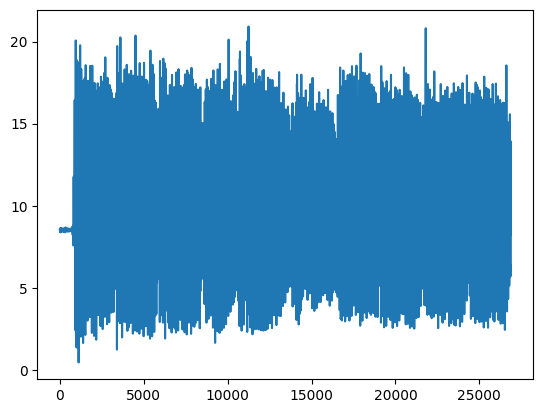

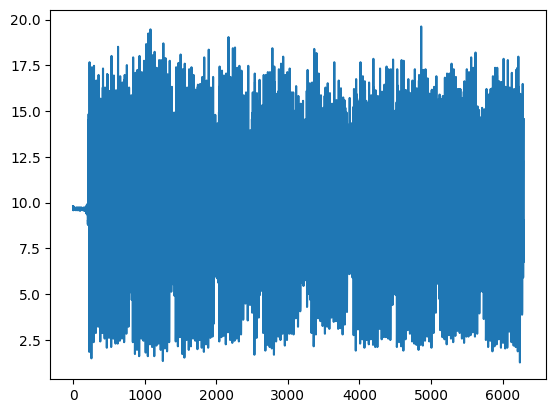

In [ ]:
def extract_condition_data(imu_data, session, sensor_position, onset, duration, fs_imu):

    # Get session data
    seek_column = f"{session}/{sensor_position}/Accelerometer"
    acc_data = imu_data.filter(regex=seek_column).to_numpy()
    seek_column = f"{session}/{sensor_position}/Gyroscope"
    gyr_data = imu_data.filter(regex=seek_column).to_numpy()
    seek_column = f"{session}/{sensor_position}/Magnetometer"
    mag_data = imu_data.filter(regex=seek_column).to_numpy()

    onset_idx = onset*fs_imu
    end_idx = duration*fs_imu

    # Cut to window
    acc_data = acc_data[onset_idx:end_idx,:]
    gyr_data = gyr_data[onset_idx:end_idx,:]
    mag_data = mag_data[onset_idx:end_idx,:]

    # Convert magnetometer data from microT to milliT
    mag_data = mag_data / 1000

    # For lumbar: as opposed to gaitmap frame, keep the original Opal frame
    # but reverse axis. This aligns with mobgap example dataset acceleration directions.
    if sensor_position == "LUMBAR":
        acc_data = -acc_data
        gyr_data = -gyr_data
        mag_data = -mag_data

    # mobgap and gaitmap wants gyro in deg/s, not rad/s as we have
    gyr_data = gyr_data * 57.2957795

    return acc_data, gyr_data, mag_data

def construct_gaitmap_dataframe(fs_imu, acc_data, gyro_data = None, mag_data = None, is_actigraph = False):
    time_axis = np.arange(0, acc_data.shape[0]) / fs_imu

    if gyro_data is None:
        gyro_data = np.zeros(acc_data.shape)
    if mag_data is None:
        mag_data = np.zeros(acc_data.shape)

    # ActiGraphs have their data in units of g, we want m/s2
    if is_actigraph:
        acc_data = acc_data*9.81

    # ActiGraphs have their axes oriented differently than MobGap data
    # so we need to replace X and Y
    if is_actigraph:
        data = {
            "acc_x": acc_data[:,1],
            "acc_y": acc_data[:,0],
            "acc_z": acc_data[:,2],
            "gyr_x": gyro_data[:,1],
            "gyr_y": gyro_data[:,0],
            "gyr_z": gyro_data[:,2],
            "mag_x": mag_data[:,1],
            "mag_y": mag_data[:,0],
            "mag_z": mag_data[:,2]
        }
    else:
        data = {
            "acc_x": acc_data[:,0],
            "acc_y": acc_data[:,1],
            "acc_z": acc_data[:,2],
            "gyr_x": gyro_data[:,0],
            "gyr_y": gyro_data[:,1],
            "gyr_z": gyro_data[:,2],
            "mag_x": mag_data[:,0],
            "mag_y": mag_data[:,1],
            "mag_z": mag_data[:,2]
        }
    df = pd.DataFrame(data, index=time_axis)

    df['samples'] = range(len(df))
    df.index = range(len(df))
    
    return df


# Get acc data for session
acc_data_lumbar, gyro_data_lumbar, mag_data_lumbar = extract_condition_data(opal_imu_data, "test", "LUMBAR", 40, 250, fs_opal)
data_opal_window = construct_gaitmap_dataframe(fs_opal, acc_data_lumbar, gyro_data=gyro_data_lumbar, mag_data=mag_data_lumbar)
print(data_opal_window)

acc_data_actigraph_window = acc_data_actigraph[40*fs_actigraph:250*fs_actigraph]
data_actigraph_window = construct_gaitmap_dataframe(fs_actigraph, acc_data_actigraph_window, is_actigraph=True)
print(data_actigraph_window)

plt.figure()
data_opal_window["acc_x"].plot()
plt.figure()
data_actigraph_window["acc_x"].plot()


# Gait sequence detection

First we run gait sequence detection with GsdIluz. We should detect one segment (because this example data is just continuous walking).

       start    end
gs_id              
0        576  26880
       start   end
gs_id             
0        180  6300


(<Figure size 640x480 with 1 Axes>, <Axes: >)

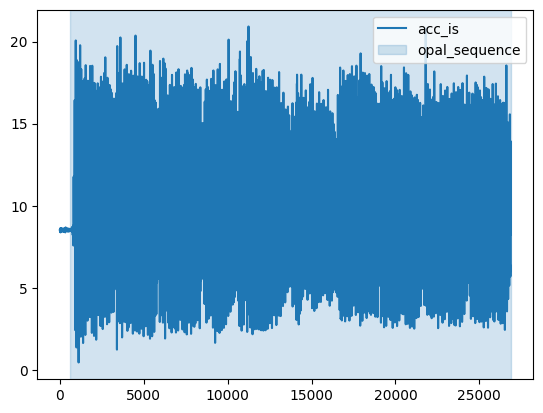

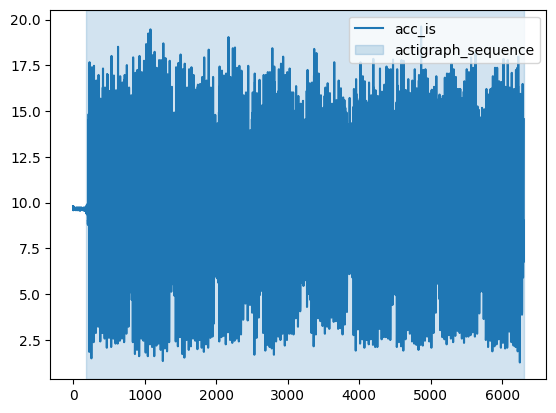

In [3]:
from mobgap.utils.conversions import to_body_frame
from mobgap.gait_sequences import GsdIluz


def plot_gsd_outputs(data, **kwargs):
    fig, ax = plt.subplots()

    ax.plot(data["acc_is"].to_numpy(), label="acc_is")

    color_cycle = iter(plt.rcParams["axes.prop_cycle"])

    y_max = 1.1
    plot_props = [
        {
            "data": v,
            "label": k,
            "alpha": 0.2,
            "ymax": (y_max := y_max - 0.1),
            "color": next(color_cycle)["color"],
        }
        for k, v in kwargs.items()
    ]

    for props in plot_props:
        for gsd in props.pop("data").itertuples(index=False):
            ax.axvspan(
                gsd.start, gsd.end, label=props.pop("label", None), **props
            )

    ax.legend()
    return fig, ax

data_opal_window_body = to_body_frame(data_opal_window)
data_actigraph_window_body = to_body_frame(data_actigraph_window)

gsd_opal = GsdIluz()
gsd_opal.detect(data=data_opal_window_body, sampling_rate_hz=fs_opal)
print(gsd_opal.gs_list_)

plot_gsd_outputs(data_opal_window_body, opal_sequence=gsd_opal.gs_list_)

gsd_actigraph = GsdIluz()
gsd_actigraph.detect(data=data_actigraph_window_body, sampling_rate_hz=fs_actigraph)
print(gsd_actigraph.gs_list_)

plot_gsd_outputs(data_actigraph_window_body, actigraph_sequence=gsd_actigraph.gs_list_)

We see that we find basically the same walking segment. It should be one segment.

# Initial contact detection

We will run IcdIonescu to find heel strikes in the data.

In [4]:
from mobgap.pipeline import GsIterator
from mobgap.initial_contacts import IcdIonescu

iterator = GsIterator()
for (gs, data), result in iterator.iterate(data_opal_window_body, gsd_opal.gs_list_):
    result.ic_list = (
        IcdIonescu().detect(data, sampling_rate_hz=fs_opal).ic_list_
    )
detected_ics_opal = iterator.results_.ic_list
print("OPAL")
print(detected_ics_opal)

iterator = GsIterator()
for (gs, data), result in iterator.iterate(data_actigraph_window_body, gsd_actigraph.gs_list_):
    result.ic_list = (
        IcdIonescu().detect(data, sampling_rate_hz=fs_actigraph).ic_list_
    )
detected_ics_actigraph = iterator.results_.ic_list
print("ACTIGRAPH")
print(detected_ics_actigraph)



OPAL
                  ic
gs_id step_id       
0     0          653
      1          720
      2          803
      3          864
      4          938
...              ...
      399      26547
      400      26611
      401      26675
      402      26746
      403      26816

[404 rows x 1 columns]
ACTIGRAPH
                 ic
gs_id step_id      
0     0         198
      1         214
      2         231
      3         246
      4         262
...             ...
      396      6218
      397      6232
      398      6248
      399      6263
      400      6279

[401 rows x 1 columns]


#### Plot initial contact detection

Opal found 404 initial contacts but ActiGraph found 401. Let's plot them to see what they are.


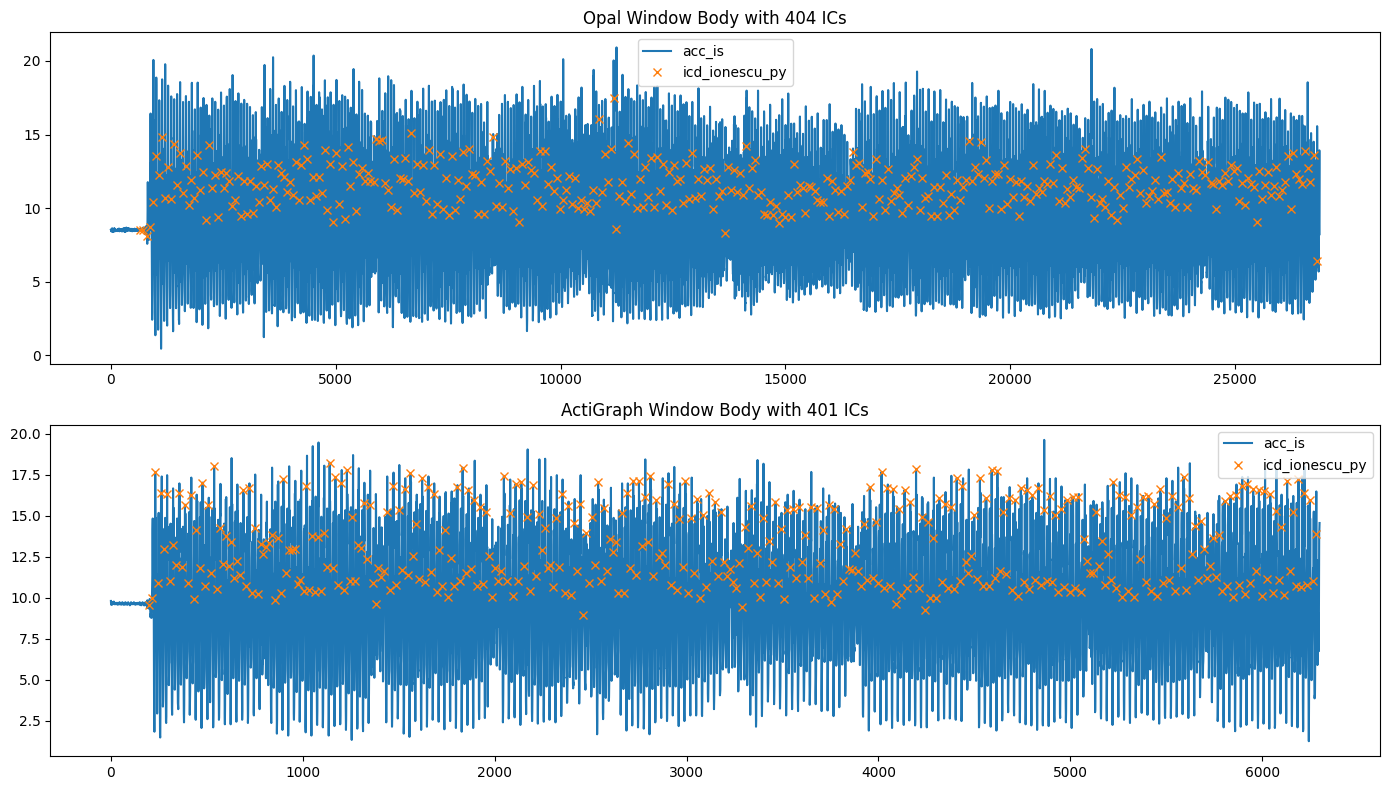

In [6]:

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# Plot for Opal data
axs[0].plot(data_opal_window_body['acc_is'], label='acc_is')
axs[0].plot(
    detected_ics_opal['ic'],
    data_opal_window_body['acc_is'].iloc[detected_ics_opal['ic']],
    'x',
    label='icd_ionescu_py'
)
axs[0].set_title(f"Opal Window Body with {len(detected_ics_opal['ic'])} ICs")
axs[0].legend()

# Plot for Actigraph data
axs[1].plot(data_actigraph_window_body['acc_is'], label='acc_is')
axs[1].plot(
    detected_ics_actigraph['ic'],
    data_actigraph_window_body['acc_is'].iloc[detected_ics_actigraph['ic']],
    'x',
    label='icd_ionescu_py'
)
axs[1].set_title(f"ActiGraph Window Body with {len(detected_ics_actigraph['ic'])} ICs")
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.show()


# Initial contact results

404 vs 401 is very close.

# Cadence estimation

Let's actually get some numbers for the step times (or cadences, which is the same thing obviously just scaled by a factor).

In [7]:
from mobgap.cadence import CadFromIc

# This is based on example
# https://mobgap.readthedocs.io/en/stable/auto_examples/cadence/_01_cad_from_ic.html

# Let's get the ICs
ics_opal = detected_ics_opal
ics_actigraph = detected_ics_actigraph

# We see that we don't want the first 4 ICs in opal data
ics_opal = ics_opal[4:]

# Estimate cadence
cad_from_ic = CadFromIc()
cad_from_ic.calculate(
    data_opal_window_body,
    initial_contacts=ics_opal,
    sampling_rate_hz=fs_opal,
)
print(cad_from_ic.cadence_per_sec_)
print(np.mean(cad_from_ic.cadence_per_sec_))

cad_from_ic = CadFromIc()
cad_from_ic.calculate(
    data_actigraph_window_body,
    initial_contacts=ics_actigraph,
    sampling_rate_hz=fs_actigraph,
)
print(cad_from_ic.cadence_per_sec_)
print(np.mean(cad_from_ic.cadence_per_sec_))

                    cadence_spm
sec_center_samples             
64                          NaN
192                         NaN
320                         NaN
448                         NaN
576                         NaN
...                         ...
26304                122.880000
26432                120.000000
26560                120.000000
26688                108.936170
26816                109.714286

[210 rows x 1 columns]
118.56930611362148
                    cadence_spm
sec_center_samples             
15                          NaN
45                          NaN
75                          NaN
105                         NaN
135                         NaN
...                         ...
6165                      120.0
6195                      120.0
6225                      120.0
6255                      112.5
6285                      112.5

[210 rows x 1 columns]
118.9481777137997


C:\project_local\actigraph_validation\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]
C:\project_local\actigraph_validation\venv\lib\site-packages\mobgap\cadence\_cad_from_ic.py:185: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  initial_contacts = self._get_ics(data, initial_contacts, sampling_rate_hz)["ic"]


# Cadence results

We find an average cadence of 118.57 from the Opal data, and 118.94 from the ActiGraph data. Very promising!

# Stride length estimation

Stride length estimation is a more difficult task with the ActiGraph data because we need to double integrate data. Sensor height is estimated from participant height.

In [8]:
from mobgap.stride_length import SlZijlstra

# This is based on example
# https://mobgap.readthedocs.io/en/stable/auto_examples/stride_length/_01_sl_zijlstra.html
sensor_height = 1.76*0.53

# Opal
sl_zijlstra = SlZijlstra(
    **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
)
sl_zijlstra.calculate(
    data=data_opal_window_body,
    initial_contacts=ics_opal,
    sensor_height_m=sensor_height,
    sampling_rate_hz=fs_opal,
)
print(sl_zijlstra.stride_length_per_sec_)
print(np.mean(sl_zijlstra.stride_length_per_sec_))

# ActiGraph
sl_zijlstra = SlZijlstra(
    **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
)
sl_zijlstra.calculate(
    data=data_actigraph_window_body,
    initial_contacts=ics_actigraph,
    sensor_height_m=sensor_height,
    sampling_rate_hz=fs_actigraph,
)
print(sl_zijlstra.stride_length_per_sec_)
print(np.mean(sl_zijlstra.stride_length_per_sec_))


                    stride_length_m
sec_center_samples                 
64                              NaN
192                             NaN
320                             NaN
448                             NaN
576                             NaN
...                             ...
26304                      1.430089
26432                      1.489250
26560                      1.456724
26688                      1.310670
26816                      1.143976

[210 rows x 1 columns]
1.4797079049088657
                    stride_length_m
sec_center_samples                 
15                              NaN
45                              NaN
75                              NaN
105                             NaN
135                             NaN
...                             ...
6165                       1.420092
6195                       1.473011
6225                       1.498404
6255                       1.520282
6285                       1.521511

[210 rows x 1 column

C:\project_local\actigraph_validation\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(
C:\project_local\actigraph_validation\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(


# Results stride length estimation

We have an average of 1.480 m from the Opal data and an average of 1.480 from the ActiGraph data. This is VERY close.

BUT, we are not using global frame acceleration for the opal data. This might bias the results.

Note that a cadence of 117 steps/min and stride length of 1.58 m is average for males (https://ouhsc.edu/bserdac/dthompso/web/gait/knmatics/stride.htm).

# Stride length estimation with global frame

We will use MadgwickAHRS for the Opal data, and leave the ActiGraph data as-is, and compare.

In [9]:
from mobgap.orientation_estimation._madgwick import MadgwickAHRS

sensor_height = 1.76*0.53

# Opal
sl_zijlstra = SlZijlstra(
    orientation_method=MadgwickAHRS(beta=0.2),
    **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
)
sl_zijlstra.calculate(
    data=data_opal_window_body,
    initial_contacts=ics_opal,
    sensor_height_m=sensor_height,
    sampling_rate_hz=fs_opal,
)
print(sl_zijlstra.stride_length_per_sec_)
print(np.mean(sl_zijlstra.stride_length_per_sec_))

# ActiGraph
sl_zijlstra = SlZijlstra(
    **SlZijlstra.PredefinedParameters.step_length_scaling_factor_ms_ms
)
sl_zijlstra.calculate(
    data=data_actigraph_window_body,
    initial_contacts=ics_actigraph,
    sensor_height_m=sensor_height,
    sampling_rate_hz=fs_actigraph,
)
print(sl_zijlstra.stride_length_per_sec_)
print(np.mean(sl_zijlstra.stride_length_per_sec_))

                    stride_length_m
sec_center_samples                 
64                              NaN
192                             NaN
320                             NaN
448                             NaN
576                             NaN
...                             ...
26304                      1.456685
26432                      1.513788
26560                      1.479546
26688                      1.398390
26816                      1.292056

[210 rows x 1 columns]
1.5183236114054823
                    stride_length_m
sec_center_samples                 
15                              NaN
45                              NaN
75                              NaN
105                             NaN
135                             NaN
...                             ...
6165                       1.420092
6195                       1.473011
6225                       1.498404
6255                       1.520282
6285                       1.521511

[210 rows x 1 column

C:\project_local\actigraph_validation\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(
C:\project_local\actigraph_validation\venv\lib\site-packages\mobgap\stride_length\_sl_zijlstra.py:228: UserWarning: Usually we assume that gait sequences are cut to the first and last detected initial contact. This is not the case for the passed initial contacts and might lead to unexpected results in the cadence calculation. Specifically, you will get NaN values at the start and the end of the output.
  warnings.warn(


# Results stride length estimation global frame

The Opal stride lengths became slightly higher, 1.51 m, while the ActiGraph is at 1.48 m.

Still, a very good correspondence on very simple gait data for a fast walk.

Next we will compare the outside data.